# **1. Import library**

In [1]:
import sys
print(sys.executable)


c:\Users\ADMIN\Documents\Jupyter Notebook\IDS-develop\vevn\Scripts\python.exe


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
import pickle
from os import path

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix,  
    classification_report,
    mean_absolute_error, 
    mean_squared_error, 
    explained_variance_score,
    f1_score,
)

from keras.src.models import Sequential
from keras.src.layers import (LSTM, Dense, Dropout, BatchNormalization)

from keras.src.optimizers import SGD

# **2. Load normalized data**

In [3]:
normalized_data = pd.read_csv('../processed_data/normalized_data.csv')
X = normalized_data.drop("attack_cat", axis=1).values
y = normalized_data["attack_cat"].values

In [4]:
X

array([[2.02463370e-03, 4.69704086e-04, 3.63042294e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.08317020e-02, 1.22123062e-03, 3.44890180e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.70521550e-02, 6.57585721e-04, 1.45216918e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.50000028e-07, 9.39408173e-05, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [5]:
y

array(['Normal', 'Normal', 'Normal', ..., 'Normal', 'Normal', 'Normal'],
      dtype=object)

In [ ]:
# Splitting data into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#Encoding y

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# **3. Balance the Dataset and Initialize Cross-Validation technique Build the CNN model**

In [ ]:
# Balance the dataset using SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
# Split the data into 6 parts while maintaining the label ratio
# Early Stopping during each fold when validation loss stops improving

# Define KFold
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
kfold.get_n_splits(X, y)



# **3. Training Logistic Regression model**

In [9]:
logr = LogisticRegression(random_state=42, max_iter=5000, solver='newton-cg',multi_class='multinomial')

# Start time
start_time = time.time()

logr.fit(X_train, y_train_encoded)

# End time
end_time = time.time()

c:\Users\ADMIN\Documents\Jupyter Notebook\IDS-develop\vevn\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [10]:
y_pred_encoded = logr.predict(X_test)

In [11]:
# Save model
pkl_filename = "../models/logistic_regressor_multi.h5"
with open(pkl_filename, 'wb') as file:
    pickle.dump(logr, file)

# **4. Confusion maxtrix**

In [12]:
target_names=[
    'Analysis', 
    'Backdoor', 
    'DoS', 
    'Exploits', 
    'Fuzzers', 
    'Generic', 
    'Normal', 
    'Reconnaissance', 
    'Shellcode', 
    'Worms'
]

In [13]:
# Create confusion matrix
confusion_matrix_result = confusion_matrix(y_test_encoded, y_pred_encoded, labels=np.arange(len(target_names)))
confusion_matrix_result

array([[   18,     0,    16,   359,    48,     0,    78,     0,     0,
            0],
       [    0,     1,    18,   346,    63,     0,    17,    23,     0,
            0],
       [    0,     0,   141,  2802,   141,    25,   107,    76,     0,
            0],
       [    0,     1,   191,  7717,   445,    33,   473,   220,     0,
            0],
       [    0,     0,    19,   534,  2064,    18,  1882,   314,     0,
            0],
       [    0,     0,     0,   197,    61, 11238,    23,    18,     0,
            0],
       [    2,     0,     0,   431,   870,     1, 16898,   411,     0,
            0],
       [    0,     0,    32,   768,   103,     7,   265,  1677,     0,
            0],
       [    0,     0,     0,     3,    50,     0,    53,   203,     0,
            0],
       [    0,     0,     0,    21,     2,    10,     0,     1,     0,
            0]])

In [14]:
# Compute confusion matrix
def plot_confusion_matrix(
        cm,
        target_names,
        title='Confusion matrix',
        cmap=None,
        normalize=True
):
    
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

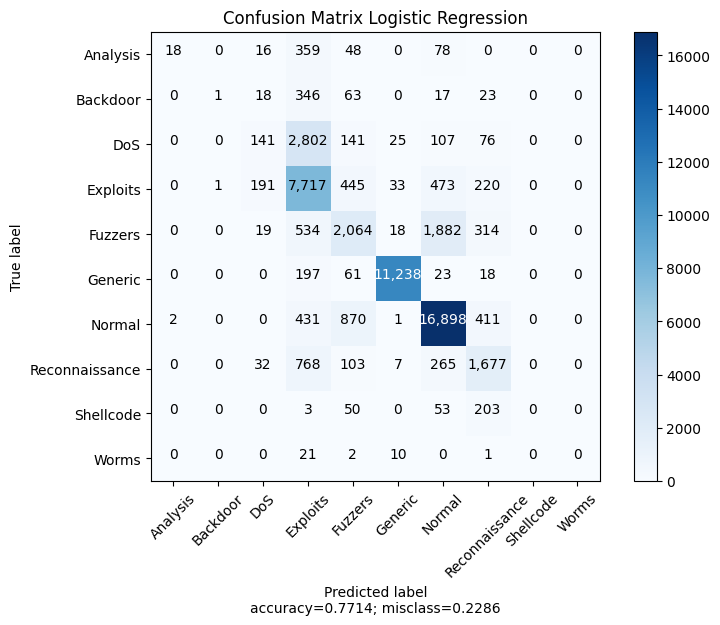

In [15]:
# Plot confusion matrix
plot_confusion_matrix(
    confusion_matrix_result, 
    normalize=False,
    target_names=target_names, 
    title="Confusion Matrix Logistic Regression"
)

# **5. Calculate metrics**

In [16]:
# Training time
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

Training time: 34.99 seconds


In [ ]:
# Tính Detection Rate và False Positive Rate
tp = np.diag(confusion_matrix_result)  # True Positives
fn = np.sum(confusion_matrix_result, axis=1) - tp  # False Negatives
fp = np.sum(confusion_matrix_result, axis=0) - tp  # False Positives

In [20]:
detection_rate = tp / (tp + fn)
fpr = fp / (fp + np.sum(confusion_matrix_result, axis=1) - tp)
df = pd.DataFrame({"Class": target_names, "False Positive Rate": fpr, "Detection Rate": detection_rate})

# Hiển thị bảng
print(df)

            Class  False Positive Rate  Detection Rate
0        Analysis             0.003976        0.034682
1        Backdoor             0.002137        0.002137
2             DoS             0.080537        0.042831
3        Exploits             0.800264        0.849890
4         Fuzzers             0.391868        0.427241
5         Generic             0.239186        0.974083
6          Normal             0.628225        0.907860
7  Reconnaissance             0.518640        0.588008
8       Shellcode             0.000000        0.000000
9           Worms             0.000000        0.000000


In [21]:
print("Mean Absolute Error - " , mean_absolute_error(y_test_encoded, y_pred_encoded))
print("Mean Squared Error - " , mean_squared_error(y_test_encoded, y_pred_encoded))
print("Root Mean Squared Error - " , np.sqrt(mean_squared_error(y_test_encoded, y_pred_encoded)))
print("R2 Score - " , explained_variance_score(y_test_encoded, y_pred_encoded)*100)
print("F1 Score - ", f1_score(y_test_encoded, y_pred_encoded, average='weighted') * 100)
print("Accuracy - ",accuracy_score(y_test_encoded, y_pred_encoded)*100)

Mean Absolute Error -  0.4589114194236926
Mean Squared Error -  1.2065974580382264
Root Mean Squared Error -  1.098452301212131
R2 Score -  49.54149675627829
F1 Score -  74.2177707778564
Accuracy -  77.13980789754535


In [22]:
print(classification_report(y_test_encoded, y_pred_encoded, target_names=target_names))

                precision    recall  f1-score   support

      Analysis       0.90      0.03      0.07       519
      Backdoor       0.50      0.00      0.00       468
           DoS       0.34      0.04      0.08      3292
      Exploits       0.59      0.85      0.69      9080
       Fuzzers       0.54      0.43      0.48      4831
       Generic       0.99      0.97      0.98     11537
        Normal       0.85      0.91      0.88     18613
Reconnaissance       0.57      0.59      0.58      2852
     Shellcode       0.00      0.00      0.00       309
         Worms       0.00      0.00      0.00        34

      accuracy                           0.77     51535
     macro avg       0.53      0.38      0.38     51535
  weighted avg       0.75      0.77      0.74     51535



c:\Users\ADMIN\Documents\Jupyter Notebook\IDS-develop\vevn\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ADMIN\Documents\Jupyter Notebook\IDS-develop\vevn\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ADMIN\Documents\Jupyter Notebook\IDS-develop\vevn\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

In [ ]:
import numpy as np

classes = np.unique(y_test_encoded)

for cls in classes:
    idx = np.where(np.array(y_test_encoded) == cls)[0]
    correct = np.sum(np.array(y_pred_encoded)[idx] == cls)
    total = len(idx)
    accuracy = correct / total if total != 0 else 0
    print(f"Class {cls}: {correct}/{total} = {accuracy:.2%} accuracy")
